# Import


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms


import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

import sys
import os
import numpy as np
import cv2
from datetime import datetime
from matplotlib import pyplot as plt

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "code"))
import dataset as D
from diff_augment import DiffAugment


# /n03452741/n03452741_17620. jpeg' different image?

# Dataset


In [2]:
root_path = "/home/choi/BrainDecoder/"
dataset_path = os.path.join(root_path, "dataset")
images_dataset_path = os.path.join(dataset_path, "imageNet_images")

config = {}

In [6]:
set_config()

In [7]:
transform = transforms.Compose(
    [
        transforms.Resize((config["img-size"][1:3])),
        transforms.ToTensor(),
        # DiffAugment(policy="color,translation,cutout"),
        DiffAugment(policy=config["diffaug-policy"]),
    ]
)

dataset = D.EEGDataset(eeg_dataset_file_name="eeg_signals_raw_with_mean_std.pth")

loaders = {
    split: DataLoader(
        dataset=D.EEGImageDataset(D.Splitter(dataset, split_name=split), transform),
        batch_size=config["batch-size"],
        shuffle=True,
    )
    for split in ["train", "val", "test"]
}

/home/choi/Downloads/miniconda3/envs/braindecoder/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


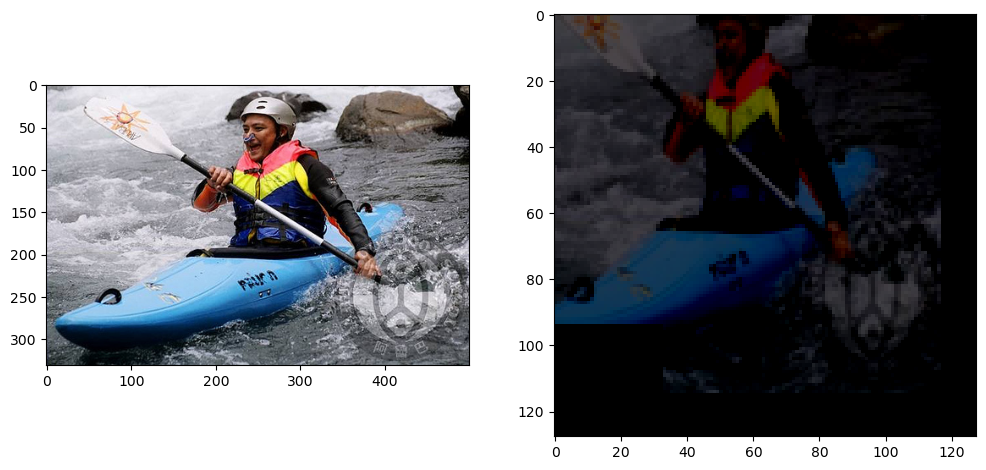

In [8]:
# Testing
transform = transforms.Compose(
    [
        transforms.Resize((config["img-size"][1:3])),
        transforms.ToTensor(),
        # DiffAugment(policy="color,translation,cutout"),
        DiffAugment(policy=config["diffaug-policy"]),
    ]
)
eeg_img_dataset = D.EEGImageDataset(D.Splitter(dataset, split_name="train"), transform)
eeg_img_dataset_original = D.EEGImageDataset(D.Splitter(dataset, split_name="train"))

idx = 1
eeg, img = eeg_img_dataset[idx]
_, img_original = eeg_img_dataset_original[idx]

plt.figure(figsize=(12, 15))
plt.subplot(1, 2, 1)
plt.imshow(img_original)
plt.subplot(1, 2, 2)
plt.imshow(img.permute(1, 2, 0))
plt.show()
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Model


In [9]:
device = "cuda2" if torch.backends.mps.is_available() else "cpu"
print(device)

cpu


In [2]:
class FeatureExtractor_ContrastiveLearning_NN(L.LightningModule):
    def __init__(self):
        super().__init__()
        # self.save_hyperparameters()

        # Triplet loss
        # def dist_fn(x1, x2):
        #     return torch.sum(torch.pow(torch.subtract(x1, x2), 2), dim=0)

        # self.loss_fn = nn.TripletMarginWithDistanceLoss(
        #     distance_function=dist_fn, margin=config["margin"]
        # )

        # model
        self.input_size = 128
        self.hidden_size = 128
        self.lstm_layers = 2
        self.out_size = 128

        self.lstm = nn.LSTM(
            self.input_size,
            self.hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
        )
        self.output = nn.Sequential(
            nn.Linear(in_features=self.hidden_size, out_features=self.out_size),
            nn.ReLU(),
        )

    def forward(self, input):
        input = input.to(device)

        lstm_out, _ = self.lstm(input)
        res = self.output(lstm_out[:, -1, :])
        return res

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()

        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + 128, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(config["img-size"]))),
            nn.Tanh(),
        )

    def forward(self, noise, condition):
        # 과연...?
        gen_input = torch.cat((condition, noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *config["img-size"])
        return img

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(config["img-size"])) + 128, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, condition):
        d_input = torch.cat((img.view(img.size(0), -1), condition), -1)
        validity = self.model(d_input)
        return validity

In [5]:
class saliency_map_GAN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.automatic_optimization = False
        self.save_hyperparameters()

        # self.data_shape = (3, 32, 32)

        self.generator = Generator()
        self.discriminator = Discriminator()

        self.feature_extractor = (
            FeatureExtractor_ContrastiveLearning_NN.load_from_checkpoint(
                config["checkpoint"]
            )
        )
        self.feature_extractor.requires_grad_(False)
        self.loss_fn = self.adversarial_loss

    def adversarial_loss(self, y_hat, y):
        # return F.binary_cross_entropy(y_hat, y)
        return F.mse_loss(y_hat, y)

    def forward(self, noise, condition):
        return self.generator(noise, condition)

    def training_step(self, batch, _):
        eegs, real_imgs = batch
        g_optim, d_optim = self.optimizers()

        batch_size = real_imgs.size(0)
        noise = torch.randn(batch_size, 100)
        noise = noise.to(device)
        real_imgs = real_imgs.to(device)

        eeg_features = self.feature_extractor(eegs)

        y_real = torch.ones([batch_size, 1], device=device, requires_grad=False)
        y_fake = torch.zeros([batch_size, 1], device=device, requires_grad=False)

        #####################
        # generator training
        #####################
        gen_imgs = self.generator(noise, eeg_features)
        y_hat = self.discriminator(gen_imgs, eeg_features)
        g_loss = self.loss_fn(y_hat, y_real)

        g_optim.zero_grad()
        self.manual_backward(g_loss)
        g_optim.step()

        #########################
        # discriminator training
        #########################
        y_hat = self.discriminator(real_imgs, eeg_features)
        d_loss_real = self.loss_fn(y_hat, y_real)

        gen_imgs = self.generator(noise, eeg_features)
        y_hat = self.discriminator(gen_imgs, eeg_features)
        d_loss_fake = self.loss_fn(y_hat, y_fake)

        d_loss = (d_loss_real + d_loss_fake) / 2

        d_optim.zero_grad()
        self.manual_backward(d_loss)
        d_optim.step()

        self.log_dict(
            {"g_loss": g_loss, "d_loss": d_loss}, prog_bar=True, on_epoch=True
        )

    # def validation_step(self, batch):
    #     return

    # def on_validation_epoch_end(self):
    #     print("HI")

    def test(self, eeg):
        noise = torch.randn(1, 100)
        eeg = eeg.unsqueeze(dim=0)
        condition = self.feature_extractor(eeg)

        noise = noise.to(device)
        condition = condition.to(device)

        return self.forward(noise, condition)

    def configure_optimizers(self):
        g_optim = optim.Adam(self.generator.parameters(), lr=1e-4, betas=(0.9, 0.999))
        d_optim = optim.Adam(
            self.discriminator.parameters(), lr=1e-4, betas=(0.9, 0.999)
        )
        # g_scheduler = optim.lr_scheduler.LambdaLR(g_optim, lambda epoch: 0.95**epoch)
        # d_scheduler = optim.lr_scheduler.LambdaLR(d_optim, lambda epoch: 0.95**epoch)
        # return [g_optim, d_optim], [g_scheduler, d_scheduler]
        return [g_optim, d_optim], []

# Training


In [7]:
def set_config():
    global config
    config = {
        "img-size": (3, 128, 128),
        "batch-size": 16,
        "diffaug-policy": "color,translation,cutout",
        "checkpoint": "/home/choi/BrainDecoder/lightning_logs/ContrastiveLossFeatureLearning/05:25_Adam_0.001_LambdaLR_margin_10.0_weight-decay_0_lambda-factor_0.975/2023-12-19 05:25:53/checkpoints/epoch=293-step=146118.ckpt",
    }


set_config()

In [91]:
model = saliency_map_GAN()
model.to(device)

logger = TensorBoardLogger(
    save_dir="/Users/ms/cs/ML/BrainDecoder/lightning_logs/SaliencyMapGAN/",
    name=f"test",
    version=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
)
lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = L.Trainer(max_epochs=200, callbacks=[lr_monitor], logger=logger)
trainer.fit(model, train_dataloaders=loaders["train"], val_dataloaders=loaders["val"])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                                    | Params
------------------------------------------------------------------------------
0 | generator         | Generator                               | 51.1 M
1 | discriminator     | Discriminator                           | 25.4 M
2 | feature_extractor | FeatureExtractor_ContrastiveLearning_NN | 280 K 
------------------------------------------------------------------------------
76.5 M    Trainable params
280 K     Non-trainable params
76.7 M    Total params
306.991   Total estimated model params size (MB)


Epoch 8:   4%|▍         | 19/498 [00:05<02:22,  3.35it/s, v_num=4:56, g_loss_step=0.000, d_loss_step=0.500, g_loss_epoch=5.93e-15, d_loss_epoch=0.500]  

# Testing


In [22]:
def test(model, eeg, img):
    model.eval()
    gen_img = model.test(eeg)
    model.train()
    gen_img = gen_img.squeeze(dim=0).cpu().detach()

    plt.figure(figsize=(12, 16))
    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(gen_img.permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


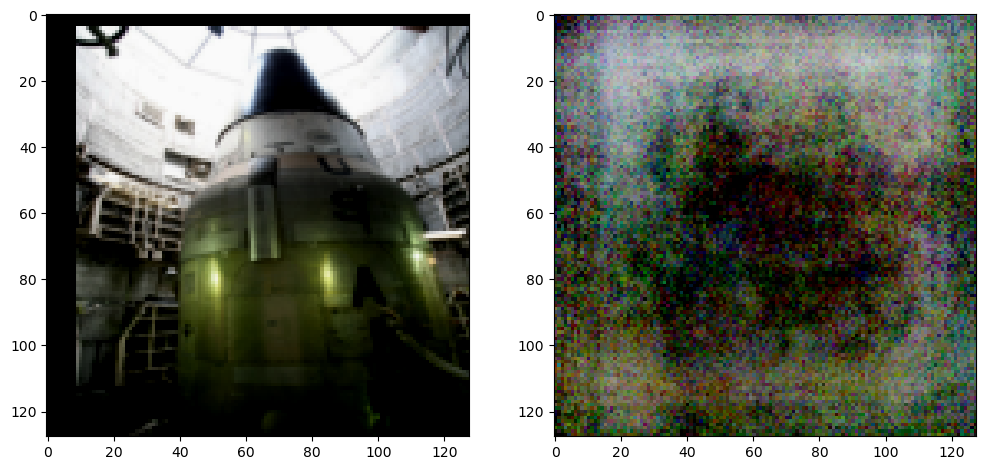

In [106]:
eeg, img = loaders["test"].dataset[4]

test(model, eeg, img)

# Test with checkpoint


In [40]:
CKPT_PATH = "/Users/ms/cs/ML/BrainDecoder/lightning_logs/SaliencyMapGAN/2023-12-07 21:11:09/checkpoints/epoch=2-step=2988.ckpt"

In [41]:
# try output one image from one random eeg. show generated image, original image
model = saliency_map_GAN.load_from_checkpoint(CKPT_PATH)
model.to(device)

RuntimeError: Error(s) in loading state_dict for saliency_map_GAN:
	size mismatch for generator.model.11.weight: copying a param with shape torch.Size([49152, 1024]) from checkpoint, the shape in current model is torch.Size([3072, 1024]).
	size mismatch for generator.model.11.bias: copying a param with shape torch.Size([49152]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for discriminator.model.0.weight: copying a param with shape torch.Size([512, 49280]) from checkpoint, the shape in current model is torch.Size([512, 3200]).

In [181]:
eeg, img = loaders["test"].dataset[20]

test(model, eeg, img)

RuntimeError: Placeholder storage has not been allocated on MPS device!